In [1]:
def count_parameters_conv(in_channels: int, out_channels: int, kernel_size: int, bias: bool):
	return (in_channels * kernel_size ** 2 + int(bias)) * out_channels

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch import optim
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.rc('font', size=30)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# def create_mlp_model():
# 	return nn.Sequential(
# 		nn.Flatten(),
# 		nn.Linear(in_features=28 * 28, out_features=200),
# 		nn.ReLU(),
# 		nn.Linear(in_features=200, out_features=100),
# 		nn.ReLU(),
# 		# nn.Linear(in_features=400, out_features=100),
# 		# nn.ReLU(),
# 		# nn.Linear(in_features=100, out_features=50),
# 		# nn.ReLU(),
# 		# nn.Linear(in_features=300, out_features=200),
# 		# nn.ReLU(),
# 		# nn.Linear(in_features=200, out_features=100),
# 		# nn.ReLU(),
# 		# nn.Linear(in_features=100, out_features=50),
# 		# nn.ReLU(),
# 		nn.Linear(100, 10),
# 		nn.Softmax()
# 	)

def create_mlp_model():
	return nn.Sequential(
		nn.Flatten(),
		nn.Linear(28 * 28, 256),
		nn.ReLU(),
		nn.Linear(256, 10)
	)

mnist_train = MNIST(
    "../datasets/mnist",
    train=True,
    download=True,
    transform=T.ToTensor()
)

mnist_valid = MNIST(
    "../datasets/mnist",
    train=False,
    download=True,
    transform=T.ToTensor()
)

batch_size = 64
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(mnist_valid, batch_size=batch_size, shuffle=False)

model = create_mlp_model().to(device)

100%|██████████| 25/25 [04:16<00:00, 10.27s/it]


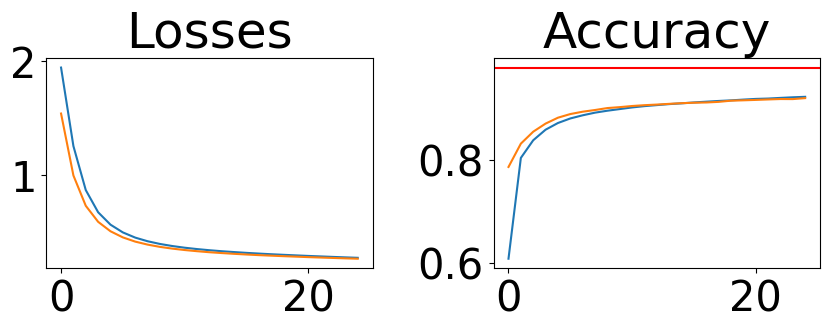

In [3]:
losses_train, losses_valid = [], []
acc_scores_train, acc_scores_valid = [], []
num_epochs=25

model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in tqdm(range(num_epochs)):
	losses, accs = [], []
	for i, (x, y) in enumerate(train_loader):
		x= x.to(device)
		optimizer.zero_grad()
		y_pred = model(x).to(torch.float64)
		y_true = torch.tensor([
			[0 if j != n else 1 for j in range(10)] 
			for n in y.numpy()
		], dtype=torch.float64).to(device)
		
		loss = loss_fn(y_pred, y_true)
		losses.append(loss.item())
		accs.append(torch.eq(y_pred.argmax(dim=1), y_true.argmax(dim=1)).sum().item() / batch_size)

		loss.backward()
		optimizer.step()

	losses_train.append(sum(losses) / len(losses))
	acc_scores_train.append(sum(accs) / len(accs))


	losses, accs = [], []
	with torch.inference_mode():
		model.eval()
		for i, (x, y) in enumerate(valid_loader):
			x = x.to(device)
			y_pred = model(x).to(torch.float64)
			y_true = torch.tensor([
				[0 if j != n else 1 for j in range(10)] 
				for n in y.numpy()
			], dtype=torch.float64).to(device)
			
			loss = loss_fn(y_pred, y_true)
			losses.append(loss.item())
			accs.append(torch.eq(y_pred.argmax(dim=1), y_true.argmax(dim=1)).sum().item() / batch_size)

	losses_valid.append(sum(losses) / len(losses))
	acc_scores_valid.append(sum(accs) / len(accs))

	model.train() 

# print(acc_score_valid / (len(valid_loader) * batch_size))

fig, ax = plt.subplots(1,2, figsize=(9,4))

ax[0].plot(losses_train, label='train')
ax[0].plot(losses_valid, label='valid')
ax[0].set_title('Losses')
ax[1].plot(acc_scores_train, label='train')
ax[1].plot(acc_scores_valid, label='valid')
ax[1].set_title('Accuracy')
ax[1].axhline(y=0.98, color='r', linestyle='-')
plt.tight_layout()
# plt.legend()

# Convolutional

In [34]:
def create_conv_model():
	return nn.Sequential(
		nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
		nn.ReLU(),
		# nn.MaxPool2d(kernel_size=2),

		nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
		nn.ReLU(),
		nn.MaxPool2d(kernel_size=2),

		nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3),
		nn.ReLU(),
		nn.MaxPool2d(kernel_size=2),

		nn.Flatten(),
		nn.Linear(512, 256),
		# nn.Linear(128, 256),
		nn.ReLU(),
		nn.Linear(256, 10)
	)

mnist_train = MNIST(
    "../datasets/mnist",
    train=True,
    download=True,
    transform=T.ToTensor()
)

mnist_valid = MNIST(
    "../datasets/mnist",
    train=False,
    download=True,
    transform=T.ToTensor()
)

batch_size = 4

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(mnist_valid, batch_size=batch_size, shuffle=False)

model = create_conv_model().to(device)


losses_train, losses_valid = [], []
acc_scores_train, acc_scores_valid = [], []
num_epochs=50

model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

for epoch in tqdm(range(num_epochs)):
	losses, accs = [], []
	for i, (x, y) in enumerate(train_loader):
		x= x.to(device)
		optimizer.zero_grad()
		y_pred = model(x).to(torch.float64)
		y_true = torch.tensor([
			[0 if j != n else 1 for j in range(10)] 
			for n in y.numpy()
		], dtype=torch.float64).to(device)
		
		loss = loss_fn(y_pred, y_true)
		losses.append(loss.item())
		accs.append(torch.eq(y_pred.argmax(dim=1), y_true.argmax(dim=1)).sum().item() / batch_size)

		loss.backward()
		optimizer.step()

	losses_train.append(sum(losses) / len(losses))
	acc_scores_train.append(sum(accs) / len(accs))


	losses, accs = [], []
	with torch.inference_mode():
		model.eval()
		for i, (x, y) in enumerate(valid_loader):
			x = x.to(device)
			y_pred = model(x).to(torch.float64)
			y_true = torch.tensor([
				[0 if j != n else 1 for j in range(10)] 
				for n in y.numpy()
			], dtype=torch.float64).to(device)
			
			loss = loss_fn(y_pred, y_true)
			losses.append(loss.item())
			accs.append(torch.eq(y_pred.argmax(dim=1), y_true.argmax(dim=1)).sum().item() / batch_size)

	losses_valid.append(sum(losses) / len(losses))
	acc_scores_valid.append(sum(accs) / len(accs))

	model.train() 

# print(acc_score_valid / (len(valid_loader) * batch_size))

fig, ax = plt.subplots(1,2, figsize=(9,4))

ax[0].plot(losses_train, label='train')
ax[0].plot(losses_valid, label='valid')
ax[0].set_title('Losses')
ax[1].plot(acc_scores_train, label='train')
ax[1].plot(acc_scores_valid, label='valid')
ax[1].set_title('Accuracy')
ax[1].axhline(y=0.992, color='r', linestyle='-')
plt.tight_layout()
# plt.legend()

  8%|▊         | 4/50 [04:17<49:16, 64.26s/it]


KeyboardInterrupt: 

In [33]:
torch.save(model.state_dict(), 'model10.pt')